In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())


2.6.0+cu124
True


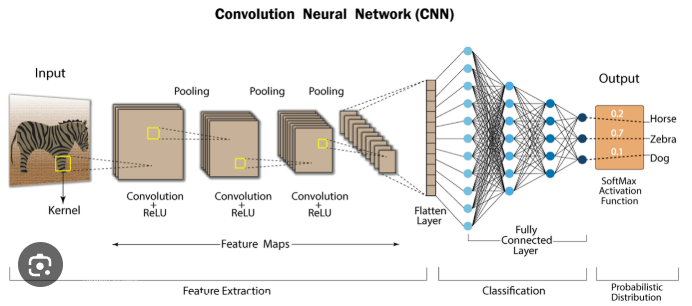

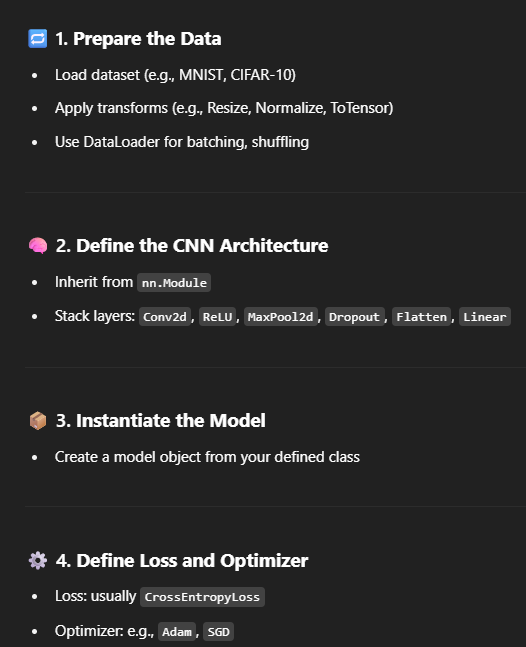

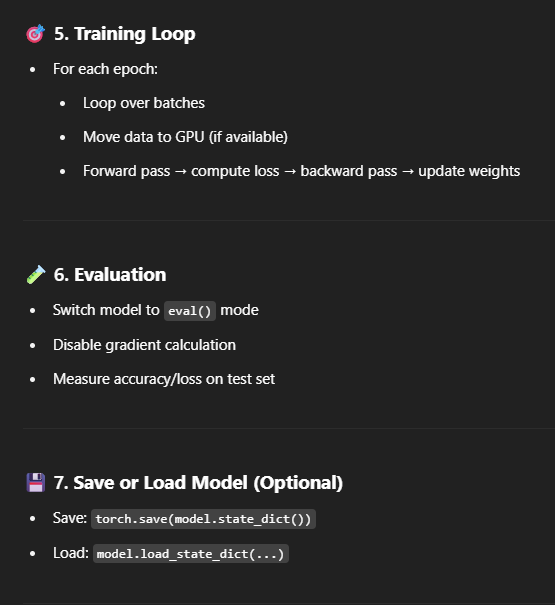

# Start

In [2]:
from google.colab import files
uploaded = files.upload()


Saving archive.zip to archive.zip


In [3]:
import zipfile
import os

# Get the uploaded file name
zip_filename = list(uploaded.keys())[0]  # gets the name of the uploaded zip file

# Define extract location
extract_to = "/content/unzipped"
os.makedirs(extract_to, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(f"/content/{zip_filename}", 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("✅ Extracted to:", extract_to)


✅ Extracted to: /content/unzipped


In [72]:
# Load in relevant libraries, and alias where appropriate
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder


# Define relevant variables for the ML task
batch_size = 64
num_classes = 2
learning_rate = 0.001
num_epochs = 20

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [73]:
# Use transforms.compose method to reformat images for modeling,
# and save to variable all_transforms for later use
all_transforms = transforms.Compose([transforms.Resize((32,32)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                                          std=[0.2023, 0.1994, 0.2010])
                                     ])
# Create Training dataset
train_dataset = ImageFolder(root="/content/unzipped/archive/train", transform=all_transforms)

test_dataset = ImageFolder(root="/content/unzipped/archive/test", transform=all_transforms)

# Instantiate loader objects to facilitate processing
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)


test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

In [74]:
train_loader.batch_size

64

In [75]:
# Creating a CNN class
class ConvNeuralNet(nn.Module):
#  Determine what layers and their order in CNN object
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.fc1 = nn.Linear(1600, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    # Progresses data across layers
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.max_pool1(out)

        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = self.max_pool2(out)

        out = out.reshape(out.size(0), -1)

        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [76]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ConvNeuralNet(num_classes)
model.to(device)

# Set Loss function with criterion
criterion = nn.CrossEntropyLoss()

# Set optimizer with optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)

total_step = len(train_loader)

In [77]:
# Get one image and label from the train set
img_train, label_train = train_dataset[0]
print("Train image shape:", img_train.shape)

# Get one image and label from the test set
img_test, label_test = test_dataset[0]
print("Test image shape:", img_test.shape)


Train image shape: torch.Size([3, 32, 32])
Test image shape: torch.Size([3, 32, 32])


In [78]:
len(train_dataset)

11879

In [79]:
len(test_dataset)

2000

# Training Loop

In [80]:
# We use the pre-defined number of epochs to determine how many iterations to train the network on
for epoch in range(num_epochs):
# Load in the data in batches using the train_loader object
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Epoch [1/20], Loss: 0.5385
Epoch [2/20], Loss: 0.5208
Epoch [3/20], Loss: 0.2935
Epoch [4/20], Loss: 0.2839
Epoch [5/20], Loss: 0.3762
Epoch [6/20], Loss: 0.4441
Epoch [7/20], Loss: 0.3481
Epoch [8/20], Loss: 0.1707
Epoch [9/20], Loss: 0.0873
Epoch [10/20], Loss: 0.1758
Epoch [11/20], Loss: 0.3140
Epoch [12/20], Loss: 0.2283
Epoch [13/20], Loss: 0.2769
Epoch [14/20], Loss: 0.1540
Epoch [15/20], Loss: 0.2944
Epoch [16/20], Loss: 0.0474
Epoch [17/20], Loss: 0.1739
Epoch [18/20], Loss: 0.1147
Epoch [19/20], Loss: 0.1426
Epoch [20/20], Loss: 0.2241


# Testing

In [81]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the {} train images: {} %'.format(2000, 100 * correct / total))

Accuracy of the network on the 2000 train images: 98.18166512332688 %


# Testing random images to see if it works

In [85]:
from google.colab import files
from PIL import Image
import torch
import torchvision.transforms as transforms

# 1. Upload the image
uploaded = files.upload()

# 2. Define the transform (must match what you used during test/train)
image_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010])
])

# 3. Load the image and preprocess it
image_path = list(uploaded.keys())[0]  # get uploaded file name
img = Image.open(image_path).convert('RGB')
img_tensor = image_transform(img).unsqueeze(0).to(device)  # [1, 3, 32, 32]

# 4. Set model to eval and predict
model.eval()
with torch.no_grad():
    output = model(img_tensor)
    _, predicted = torch.max(output.data, 1)

# 5. Get class names (from your dataset)
class_names = train_dataset.classes  # e.g., ['benign', 'malignant']
print("Predicted class index:", predicted.item())
print("Predicted label:", class_names[predicted.item()])


Saving 5628.jpg to 5628.jpg
Predicted class index: 1
Predicted label: Malignant
